### Probabilistic spiker neuron

In [1]:
import sys

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Use included models directory
# models_dir=None

# Use external models directory (containing ncProcessModels for Loihi)
models_dir='/home/jlubo/brian2lava-models/models'
#models_dir='/homes/jlubo/brian2lava-models/models'
#models_dir='/homes/francesco.negri/B2L/brian2lava-models/models'

# Set device, choosing CPU with fixed-point representation, but switching off F2F conversion
set_device('lava', mode='preset', hardware='CPU', num_repr='fixed', use_f2f=False, models_dir=models_dir)
BrianLogger.log_level_debug()

WARNING    The name of one (or more) models defined in the given model directory '/home/jlubo/brian2lava-models/models' already exists in Brian2Lava's standard model library. Note that user-defined models will always override standard models. If you do not want this to happen, rename your model folder(s). [brian2lava.preset_mode.model_loader]


In [4]:
# Import probspiker model
from brian2lava.preset_mode.model_loader import probspiker

In [5]:
# Set seed (not available on Loihi)
#seed(1)

# Set defaultclock
defaultclock.dt = 0.5*ms

In [6]:
print(probspiker.equations, type(probspiker.equations))
print(probspiker.conditions)

rnd = rand() : 1 (constant over dt)
p_spike : 1 <class 'brian2.equations.equations.Equations'>
{'th': 'rnd < p_spike', 'rs': ''}


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


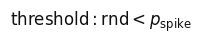



Brian 2 equations                                                               
--------------------------------------------------------------------------------
rnd = rand() : 1 (constant over dt)                                             
p_spike : 1                                                                     


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : rnd < p_spike                                                              
rs :                                                                            


Refractory period                                                               
--------------------------------------------------------------------------------
<not supported>


Variables                                                                       
--------------------------------------------------------------------------------
+---

In [7]:
probspiker.show()

In [8]:
# Define parameters
N = 3
p_spike_0 = np.clip(50*Hz * defaultclock.dt, 0, 1)  # spiking probability per time bin
print(f"p_spike_0 = {p_spike_0}")

# Add a neuron group
P = NeuronGroup(N, probspiker.equations, threshold=probspiker.conditions["th"], reset='')
P.p_spike = p_spike_0

# Add another neuron group
Q = NeuronGroup(N, probspiker.equations, threshold=probspiker.conditions["th"], reset='')
Q.p_spike = p_spike_0

p_spike_0 = 0.025


In [9]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [10]:
# Add monitors for spikes
spmP = SpikeMonitor(P, variables='rnd', record=True)
spmQ = SpikeMonitor(Q, variables='rnd', record=True)

# Add monitors for rnd state
stmP = StateMonitor(P, variables=['rnd', 'p_spike'], record=True)
stmQ = StateMonitor(Q, variables=['rnd', 'p_spike'], record=True)

DEBUG      Monitor _spike_spikemonitor_rnd not added yet, will add the additional var monitor for rnd later. [brian2.devices.lava]
DEBUG      Monitor _spike_spikemonitor_1_rnd not added yet, will add the additional var monitor for rnd later. [brian2.devices.lava]


In [11]:
# Run simulation
#run(30*second)
run(30*ms)

DEBUG      Updated MagicNetwork to include 14 objects with names statemonitor_1, statemonitor, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_1_stateupdater, neurongroup_1_subexpression_update, neurongroup_subexpression_update, neurongroup_spike_resetter, neurongroup_1_spike_resetter, spikemonitor_1, neurongroup_spike_thresholder, spikemonitor, neurongroup, neurongroup_1 [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 14 objects: neurongroup_1_subexpression_update, neurongroup_subexpression_update, neurongroup, neurongroup_1, statemonitor, statemonitor_1, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikemonitor, spikemonitor_1, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]
DEBUG      Network 'magicnetwork' uses 1 clocks: defaultclock (dt=0.5 ms) [brian2.core.network.before_run]
DEBUG      lava_objects = {'neuron

In [12]:
# Readout of last values
print(f"P.rnd = {P.rnd}")
print(f"P.rnd = {P.p_spike}")
print(f"Q.rnd = {Q.rnd}")
print(f"Q.rnd = {Q.p_spike}")

P.rnd = <neurongroup.rnd: array([0.26373166, 0.05751544, 0.98951846])>
P.rnd = <neurongroup.p_spike: array([0.02499998, 0.02499998, 0.02499998])>
Q.rnd = <neurongroup_1.rnd: array([0.93969983, 0.58725208, 0.91333777])>
Q.rnd = <neurongroup_1.p_spike: array([0.02499998, 0.02499998, 0.02499998])>


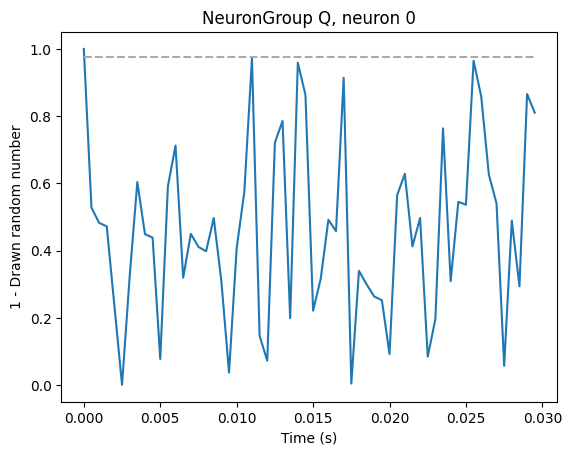

In [13]:
# Plotting for NeuronGroup P
plt.plot(stmP.t/second, 1 - stmP.rnd[0])
plt.plot(stmP.t/second, 1 - stmP.p_spike[0], linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (s)')
ylabel('1 - Drawn random number')
show()

# Plotting for NeuronGroup Q
plt.plot(stmQ.t/second, 1 - stmQ.rnd[0])
plt.plot(stmQ.t/second, 1 - stmQ.p_spike[0], linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup Q, neuron 0')
xlabel('Time (s)')
ylabel('1 - Drawn random number')
show()

In [14]:
# Checking mean of random numbers
print(f"mean(P.rnd) = {np.mean(stmP.rnd, axis=1)} (from {stmP.rnd.shape[1]} data points).")
print(f"mean(Q.rnd) = {np.mean(stmQ.rnd, axis=1)} (from {stmP.rnd.shape[1]} data points).")

mean(P.rnd) = [0.48920299 0.45371317 0.49291881] (from 60 data points).
mean(Q.rnd) = [0.5378763  0.48112536 0.44458616] (from 60 data points).


In [15]:
print("NeuronGroup P:")
print("  ", len(spmP.i), "spikes occurred in total.")
print("  ", spmP.t)
print("  ", spmP.i)
print("  ", spmP.rnd)
print("NeuronGroup Q:")
print("  ", len(spmQ.i), "spikes occurred in total.")
print("  ", spmQ.t)
print("  ", spmQ.i)
print("  ", spmQ.rnd)

NeuronGroup P:
   3 spikes occurred in total.
   <spikemonitor.t: array([ 1.5, 16. , 20. ]) * msecond>
   <spikemonitor.i: array([0, 0, 0])>
   <spikemonitor.rnd: array([0.80811119, 0.68863487, 0.46064889])>
NeuronGroup Q:
   5 spikes occurred in total.
   <spikemonitor_1.t: array([ 7.5, 10.5, 19. , 22. , 28. ]) * msecond>
   <spikemonitor_1.i: array([2, 1, 1, 2, 2])>
   <spikemonitor_1.rnd: array([0.89331239, 0.82029277, 0.57442355, 0.5856688 , 0.53972322])>
